# Foundation of Probability and Statistics
# TRADING CARDS GAME: MAGIC THE GATHERING ANALYSIS

<div align="right"><b>by Emanuele Artioli</b></div>
<div align="center"><b>ABSTRACT</b></div>
This project analyzes the esthetics and functional characteristics of the entire database of Magic the Gathering trading card game since 1993. 
<div align="center"><b>THE GAME</b></div>
Briefly, this game consists in a duel between sorcerers, taking turns in casting spells, represented by the cards in their hands. Spells require elemental energy to cast, which can be aquired by land cards. Each basic land card (Plains, Island, Swamp, Mountain, Forest) corresponds to a color of the mana it produces (White, Blue, Black, Red, Green). This mana lets sorcerers cast various types of spells: Creatures, Artifacts, Enchantments, Sorceries, Instants, ecc.
<div align="center"><b>THE DATA</b></div>
The data was acquired from https://mtgjson.com/, and imported in the form of a SQLite database, therefore the library RSQLite was installed. In particular we imported the tables:
<ul>
    <li>cards, containing a huge amount of information for each card
    <li>prices, with their latest market price
    <li>legalities, for the various formats each card can be played
</ul>
It is worthwhile to mention that many of the data present in the tables are unnecessary for the scope of this analysis, and have therefore been removed. Others were not suitable in their original form and were reformatted.

In [1]:
library(dplyr)
library(ggplot2)

library(DBI)
con <- dbConnect(RSQLite::SQLite(), dbname="AllPrintings.sqlite")

#--------------------------------------------------------------------

# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

#--------------------------------------------------------------------------------------------------


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
cards <- data.frame(dbReadTable(con, "cards"))
prices <- data.frame(dbReadTable(con, "prices"))
legalities <- data.frame(dbReadTable(con, "legalities"))

prices <- prices[grep("paper", prices$type), c("uuid", "price")] #only paper prices
prices <- prices %>% group_by(uuid) %>% summarize(price = min(price)) #there are cards that have variations, only the cheapest will be included

legacy <- legalities[grep("legacy", legalities$format), "uuid"] #only legacy-legal cards

cards <- cards[cards$isPaper == 1, ]         #only paper,
cards <- cards[cards$isOversized == 0, ]     #usual dimension,
cards <- cards[cards$layout == "normal", ]   #normal layout,
cards <- cards[cards$borderColor == "black", ] #black bordered,
cards <- cards[cards$uuid %in% legacy, ]     #legacy legal cards

#binarizing colors:
cards$white <- 0
cards$white[grep("W", cards$colorIdentity)] <- 1
cards$blue <- 0
cards$blue[grep("U", cards$colorIdentity)] <- 1
cards$black <- 0
cards$black[grep("B", cards$colorIdentity)] <- 1
cards$red <- 0
cards$red[grep("R", cards$colorIdentity)] <- 1
cards$green <- 0
cards$green[grep("G", cards$colorIdentity)] <- 1
colnames(cards)[colnames(cards) == "colorIdentity"] <- "colorless" #colorIdentity becomes the colorless column
cards$colorless[!is.na(cards$colorless)] <- 0 #the rows where colorIdentity had value get colorless = 0
cards$colorless[is.na(cards$colorless)] <- 1 #the remaining (where colorIdentity was NA) get 1

#setting the data types correctly:
suppressWarnings(cards$loyalty <- cards$loyalty %>% as.numeric())
suppressWarnings(cards$power <- cards$power %>% as.numeric())
suppressWarnings(cards$toughness <- cards$toughness %>% as.numeric())
suppressWarnings(cards$colorless <- cards$colorless %>% as.numeric())

# joining the tables in a single dataframe
df <- merge(cards, prices, by="uuid")

# dropping cards columns:
df <- df[, c("name", "convertedManaCost", "white", "blue", "black", "red", "green", "colorless", "supertypes", "types", "subtypes", "rarity", 
             "setCode", "loyalty", "power", "toughness", "price")]

After managing, the final dataset consists of 41033 rows (cards) each one with the following variables:
<table>
  <tr>
    <td><b>Attribute</b></td>
    <td><b>Description</b></td>
    <td><b>Values</b></td>
  </tr>
  <tr>
    <td><b>artist</b></td>
    <td>Full name of the artist who drew the image</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>colorIdentity</b></td>
    <td>One or more color identities attributed to the card</td>
    <td>"W", "U", "B", "R", "G"</td>
  </tr>
  <tr>
    <td><b>manaCost</b></td>
    <td>How much of each mana type is required to cast the spell</td>
    <td>Character (sequence of a numeric, standing for the free color mana, and a series of mandatory colored mana)</td>
  </tr>
  <tr>
    <td><b>convertedManaCost</b></td>
    <td>the total amomunt of mana required to cast the spell</td>
    <td>Numeric (total sum of the previous attribute, range 0 - 16)</td>
  </tr>
  <tr>
    <td><b>flavorText</b></td>
    <td>non game-related, a tale about the role of the card in the Magic ecosystem</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>isReserved</b></td>
    <td>whether the card is banned from reprints (usually because it's too powerful and ruins the matches)</td>
    <td>Boolean (1.076% of the cards are Reserved)</td>
  </tr>
  <tr>
    <td><b>name</b></td>
    <td>the card's name</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>rarity</b></td>
    <td>The rarity influences the chance of a card being found in a booster pack.</td>
    <td>"Common", "Uncommon", "Rare", or "Mythic"</td>
  </tr>
  <tr>
    <td><b>supertypes</b></td>
    <td>Some cards have a supertype linked to a particular game rule.</td>
    <td>"Legendary", "Snow", "Basic", "World"</td>
  </tr>
  <tr>
    <td><b>types</b></td>
    <td>the main discriminator among cards, defining its nature</td>
    <td>"Creatures", "Artifacts", "Enchantments", "Sorceries", "Instants", "Planeswalkers", "Lands"</td>
  </tr>
  <tr>
    <td><b>subtypes</b></td>
    <td>The most specific characterization of the card. Usual for Creatures and Planeswalkers, optional for artifacts, enchantments, instants, sorceries and lands</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>loyalty</b></td>
    <td>(only for the Planeswalker type) value of loyalty the card enters the battlefield with</td>
    <td>Numeric (range 2 - 7)</td>
  </tr>
  <tr>
    <td><b>power</b></td>
    <td>(only for the Creature type) The damage this creature deals to other creatures and players in a fight</td>
    <td>Numeric (range -1 - 16)</td>
  </tr>
  <tr>
    <td><b>toughness</b></td>
    <td>(only for the Creature type) The damage this creature can sustain before dying</td>
    <td>Numeric (range -1 - 16)</td>
  </tr>
  <tr>
    <td><b>setCode</b></td>
    <td>The edition of this instance of the card</td>
    <td>A 3 to 4 character</td>
  </tr>
  <tr>
    <td><b>text</b></td>
    <td>The effects of the card</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>uuid</b></td>
    <td>unique identifier of the card</td>
    <td>Character</td>
  </tr>
</table>

## The Dataset in general

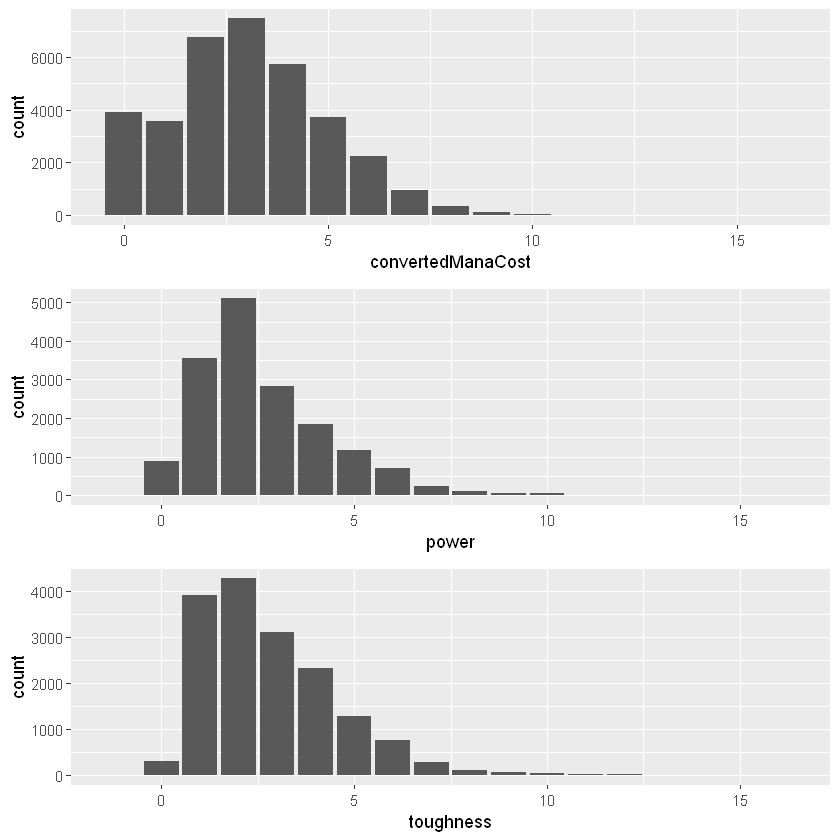

In [3]:
cmc <- ggplot(df, aes(x = convertedManaCost)) +
    geom_bar()
power <- ggplot(df, aes(x = power)) +
    geom_bar()
toughness <- ggplot(df, aes(x = toughness)) +
    geom_bar()

suppressWarnings(
    multiplot(cmc, power, toughness, cols=1)
)